# Task2
## High Level State Representation
- Data is generated by an "expert" player.
- $timeout -sHUP 30m python ./lunar_lander_data_gen.py
    - generates data for 10 minutes
    - saves high level state representation as state_vectors_*.csv
    - saves image files in ./frames/2018-*/frame_2018_*.jpeg
- Train and evaluate a number of supervised machine learning models to predict actions of an "expert" player based off high level state representations


- Model saved as:
    - ml_images_player.mod
    

- Process: CRISP-DM
    - Iterating over this workflow
    - Assessing data, modeling, evaluating, re-developing
    - e.g. Strong accuracies, but poor flight from imbalanced dataset 
            -> undersampling
    - e.g. Initial learning curves implied immature models 
            -> generate more data.
    

## Nueral Net Overview:

All Nueral Nets are capable of capturing highly non-linear patterns (provided they allow use non-linear activation functions). This allows them to capture complex relationship and understand varieties of representations of data. These models tend to have a lot of freedom and can easily be overtrained. Adding some constraints to these models (removing some freedom) can lead to better, faster, more compact learners making them more practical.

Nueral Nets can be considered as layers of nodes. There is an input layer (which recieve input data, and output layer which outputs the data from the model, perhaps a class_label. Between the input and output layers there are hidden layes which recieve inputs from a previous layer and provide an output to a subsequent layer within the model.

Nodes in each layer have a forward connection to nodes in the subsequent layer. Connections can be dense, where nodes have many connections to subsequent layer. In contrast, nodes that have relatively few connections to the subsequent layer have sparse connectivity.

Nodes have activation functions to transform their input. Similarly connections have weights, which allows for subsequent nodes to favor inputs from some nodes more than others. Models are trained by altering these wait through back propagation, to optimise some defined loss function.


## Imports

In [1]:
import os 
import cv2
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

from matplotlib import ticker
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import  GridSearchCV, StratifiedKFold, \
                                     cross_val_score
from imblearn.under_sampling import RandomUnderSampler

from sklearn.utils import shuffle

import keras
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop, adam
from keras.utils import np_utils, plot_model

from my_lib import topn, plot_learning_curve

from keras import backend as K
K.set_image_data_format('channels_first')

Using TensorFlow backend.


### View Images Folder

In [2]:
ls ./frames

2018-04-21-20-41-25/


## Plug In Data

In [3]:

#Other user
#TRAIN_DIR = './frames/something..etc/'

#Andy
TRAIN_DIR = './frames/2018-04-21-20-41-25/'

#Conor
#TRAIN_DIR = '../frames/2018-04-20-15-12-38/'


## Experiment Parameters

In [4]:
sample_rate = 0.1
ROWS = 64
COLS = 64
CHANNELS = 1

#Stratify to preserve label weightings
grid_search_cv_folds = StratifiedKFold(3, shuffle=True) #keep this small
cv_experiment_folds = StratifiedKFold(3, shuffle=True)  #better to keep this a bit bigger. 8 or 10
learning_curve_folds = StratifiedKFold(3, shuffle=True) #keep this small

## Prepare Dataset
- Convert images into greyscale
- Shrinking Images; flattened 64x64 array 
- Normalising Image Data; 
- Undersampling data
- Storing in np.ndarray for efficiency (less overhead that pd.DataFrame), and typing is uniform.
- Sampling data for efficiency

In [5]:
# generate filenames from the data folder and do sampling
def sample_files(train_dir):
    image_filenames = [train_dir+i for i in os.listdir(train_dir) if not i.startswith('.')] # use this for full dataset
    sample_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))
    return sample_filenames

sample_filenames = sample_files(TRAIN_DIR)

# Init a data array for image data
count = len(sample_filenames)
X = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.float)

# Iterate throuigh the filenames and for each one load the image, resize and normalise
for i, image_file in enumerate(sample_filenames):
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)        
    X[i] = image
    X[i] = X[i]/255
    if i%1000 == 0: print('Processed {} of {}'.format(i, count))

print("Train shape: {}".format(X.shape))

Processed 0 of 3848
Processed 1000 of 3848
Processed 2000 of 3848
Processed 3000 of 3848
Train shape: (3848, 1, 64, 64)


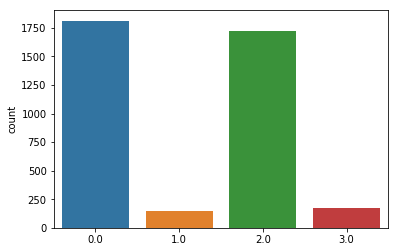

In [6]:
# Extract the lables from the last characters in the filename
y = np.empty(count)
for idx, i in enumerate(sample_filenames):
    l = i[-6:-5]
    y[idx] = l
        
# Count the number of clases
num_classes = len(set(y))

# convert to binary encoded labels
labels_wide = keras.utils.to_categorical(y, num_classes)

# Plot a bar plot of the 
sns.countplot(y)

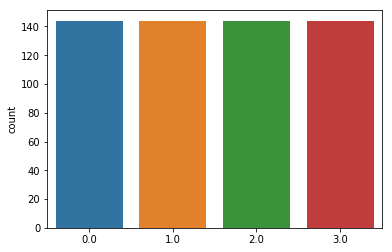

In [7]:
rus = RandomUnderSampler(return_indices=True)
# Neat Trick : -1 infers missing argument in reshape
X_rus, y_rus, idx_resampled = rus.fit_sample(X.reshape(-1, ROWS*COLS*CHANNELS), y)
X_rus, y_rus = shuffle(X_rus, y_rus)
X_rus = X_rus.reshape(-1, CHANNELS,ROWS,COLS)
sns.countplot(y_rus)
y_rus_wide = keras.utils.to_categorical(y_rus, num_classes)


2.0


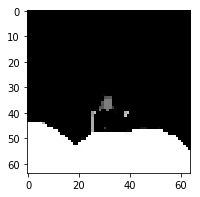

0.0


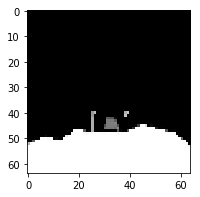

1.0


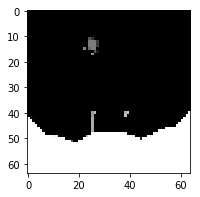

2.0


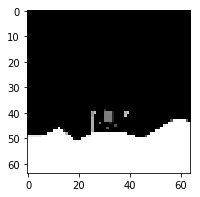

0.0


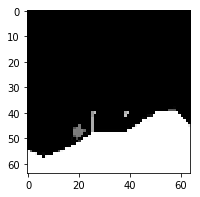

In [8]:
#show some screens
for i in range(0,5):
    idx = random.randint(0, len(y_rus))
    print(y_rus[idx])
    plt.figure(figsize=(3,3))
    plt.imshow(X_rus[idx][0], cmap='gray')
    plt.show()

In [9]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, random_state=0, test_size = 0.2, train_size = 0.8)
y_train_wide = keras.utils.to_categorical(y_train, num_classes)
y_test_wide =  keras.utils.to_categorical(y_test, num_classes)

# Define Keras Models

In this task we build, test, tune and evaluate several different model architectures.

- SingleLayerPerceptron
    - Input -> output
    - no hidden layers


- MultiLayerPerceptron
    - Input -> hidden -> output
    - single hidden layer


- Deep Feed Forward Nueral Network
    - Input -> hidden -> hidden -> ... -> output
    - multiple hidden layers


- Convolutional Nueral Network CNN
    - Input -> Convolutions & Pooling -> ... -> Flat Densly Connected -> softmax output
    - Generally accepted as the most suitable architecture for image classification.
    - Should identify Lander and the direction in which it projects fuel.
    - Uses shared weights:
        - Provides Translation Invariance: (Convinient Property)
            - All nodes in a layer share a weight-vector/filter for their inbound connections.
            - An object may occur at different positions in the dataset.
            - But it is still handled in the same way by the filters.
        - Reduces freedom in the model (faster training, and less overfitting.)
            - The model trains these shared weights.
        - Lower memory requirements, faster training and predictions.
    - Sparse Connections:
        - Makes back propagation easier.
        - Focuses on local connections; receptive field.
        - Reduces overfitting
    - Pooling:
        - Aggregates the output of a filter.
        - Reduces dimensionality within network.
        - Model is more compact, faster training and predictions.
    - These method allow the model to go deeper with less drawbacks.


In [10]:
flat_shape =  (CHANNELS*ROWS*COLS,)
image_shape = (CHANNELS, ROWS, COLS,)


def SLP():
    model = Sequential()
    model.add(Dense(num_classes, input_shape=flat_shape, use_bias=False, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=adam(lr=1e-3), metrics=['accuracy'])
    return model

def MLP():
    model = Sequential()
    model.add(Dense(8, input_shape=flat_shape, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=adam(lr=1e-3), metrics=['accuracy'])
    return model
              

def DFFNN(dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(8, input_shape=flat_shape, activation='relu'))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=adam(lr=1e-3), metrics=['accuracy'])
    return model


def CNN(dropout_rate=0.0):
    model = Sequential()
    model.add(Conv2D(8, (3, 3), padding='same', input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(8, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=dropout_rate))
    model.add(Flatten())
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=adam(lr=1e-3), metrics=['accuracy'])
    return model


## Search Space

In [11]:

# list all build architectures to be explored
clfs = [SLP, MLP, DFFNN, CNN]
input_shapes = {
    'SLP':flat_shape,
    'MLP':flat_shape,
    'DFFNN':flat_shape,
    'CNN':image_shape
}

model_params = set(['dropout_rate',])
fit_params = set(['epochs', 'batch_size', 'validation_split','shuffle'])

param_grids= {
    'SLP': {
        "epochs":list(range(3,5,5)),   
        "batch_size":[2**i for i in range(7,8)], #powers of 2
        "validation_split":[0.25,],
        "shuffle":[True],
    },
    'MLP': {
        "epochs":list(range(3,5,5)),   
        "batch_size":[2**i for i in range(7,8)], #powers of 2
        "validation_split":[0.25,],
        "shuffle":[True],
    },
    'DFFNN' : {
        "epochs":list(range(3,5,5)),   
        "batch_size":[2**i for i in range(7,8)], #powers of 2
        "validation_split":[0.25,],
        "shuffle":[True],
        'dropout_rate':[0.1]
    },
    'CNN' : {
        "epochs":list(range(3,5,5)),   
        "batch_size":[2**i for i in range(7,8)], #powers of 2
        "validation_split":[0.25,],
        "shuffle":[True],
        'dropout_rate':[0.1]
    }
}


## Execute Search

In [12]:
%%time
# store the best params and scores for each classifier
stored_grid_searches={}

# running grid search for each classifier
for clf in clfs:
    clf_name = str(clf).split()[1]
    input_shape = input_shapes[clf_name]
    current_GS = GridSearchCV(KerasClassifier(build_fn=clf, verbose=0), 
                              param_grids[clf_name],
                              cv=grid_search_cv_folds,
                              verbose=0,
                              refit=True,
                              return_train_score=True).fit(
        X_train.reshape(-1, *input_shape), y_train)
    
    # store grid search object for each classifier
    stored_grid_searches[clf_name] = current_GS

CPU times: user 1min 14s, sys: 907 ms, total: 1min 15s
Wall time: 46.2 s


### Inspect Search Results

- GridSearch results are double checked
- Models are considered on train/prediction times and accuracy.
- In each case, the best params were judged to be those identified by the grid search.

In [13]:
#store selcted params for each classifier
selected_params={}
    

In [14]:
#print top10 results
SLP_GS = stored_grid_searches['SLP']
topn(SLP_GS, 10).round(3)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_batch_size,param_epochs,param_shuffle,param_validation_split,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.372,0.005,0.248,0.313,128,3,True,0.25,"{'batch_size': 128, 'validation_split': 0.25, ...",1,0.245,0.308,0.229,0.287,0.27,0.344,0.028,0.001,0.017,0.024


In [15]:
print("best params:", SLP_GS.best_params_)
print("best score:", SLP_GS.best_score_)

#store best random forest
selected_params['SLP'] = SLP_GS.best_params_

best params: {'batch_size': 128, 'validation_split': 0.25, 'epochs': 3, 'shuffle': True}
best score: 0.247826087313


In [16]:
#print top10 results
MLP_GS = stored_grid_searches['MLP']
topn(MLP_GS, 10).round(3)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_batch_size,param_epochs,param_shuffle,param_validation_split,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.569,0.005,0.267,0.261,128,3,True,0.25,"{'batch_size': 128, 'validation_split': 0.25, ...",1,0.258,0.256,0.288,0.27,0.257,0.256,0.054,0.0,0.014,0.007


In [17]:
print("best params:", SLP_GS.best_params_)
print("best score:", SLP_GS.best_score_)

#store best random forest
selected_params['MLP'] = MLP_GS.best_params_

best params: {'batch_size': 128, 'validation_split': 0.25, 'epochs': 3, 'shuffle': True}
best score: 0.247826087313


In [18]:
#print top10 results
DFFNN_GS = stored_grid_searches['DFFNN']
topn(DFFNN_GS, 10).round(3)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_batch_size,param_dropout_rate,param_epochs,param_shuffle,param_validation_split,params,...,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,1.079,0.005,0.267,0.265,128,0.1,3,True,0.25,"{'batch_size': 128, 'dropout_rate': 0.1, 'vali...",...,0.265,0.262,0.268,0.267,0.27,0.266,0.02,0.0,0.002,0.002


In [19]:
print("best params:", DFFNN_GS.best_params_)
print("best score:", DFFNN_GS.best_score_)

#store best random forest
selected_params['DFFNN'] = DFFNN_GS.best_params_

best params: {'batch_size': 128, 'dropout_rate': 0.1, 'validation_split': 0.25, 'epochs': 3, 'shuffle': True}
best score: 0.267391303279


In [20]:
#print top10 results
CNN_GS = stored_grid_searches['DFFNN']
topn(DFFNN_GS, 10).round(3)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_batch_size,param_dropout_rate,param_epochs,param_shuffle,param_validation_split,params,...,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,1.079,0.005,0.267,0.265,128,0.1,3,True,0.25,"{'batch_size': 128, 'dropout_rate': 0.1, 'vali...",...,0.265,0.262,0.268,0.267,0.27,0.266,0.02,0.0,0.002,0.002


In [21]:
print("best params:", CNN_GS.best_params_)
print("best score:", CNN_GS.best_score_)

#store best random forest
selected_params['CNN'] = CNN_GS.best_params_

best params: {'batch_size': 128, 'dropout_rate': 0.1, 'validation_split': 0.25, 'epochs': 3, 'shuffle': True}
best score: 0.267391303279


## 10xCV Experiment : Train Set

In [22]:
%%time
# 10xCV on sample data using selected params
cv_scores = {}
for clf in clfs:
    clf_name = str(clf).split()[1]
    input_shape = input_shapes[clf_name]
    params = selected_params[clf_name]
    cv_scores[clf_name] = np.mean(cross_val_score(KerasClassifier(build_fn=clf,**params, verbose=0),
                                                  X_train.reshape(-1, *input_shape), 
                                                  y_train, cv=cv_experiment_folds,
                                                 )
                                 ) 



CPU times: user 54.7 s, sys: 387 ms, total: 55.1 s
Wall time: 37.9 s


In [23]:
# print the avg CVx10 score.
pd.DataFrame(cv_scores, [0]).round(3)

,CNN,DFFNN,MLP,SLP
0,0.252,0.259,0.241,0.27


## Learning Curves : Train Set
#### === THIS WILL TAKE A WHILE ===

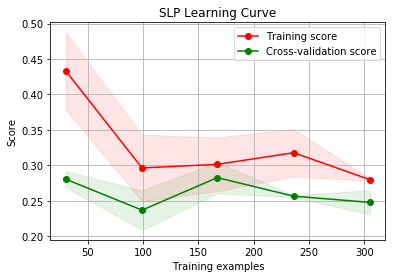

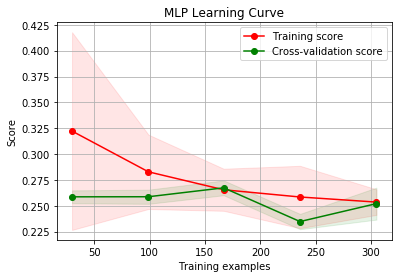

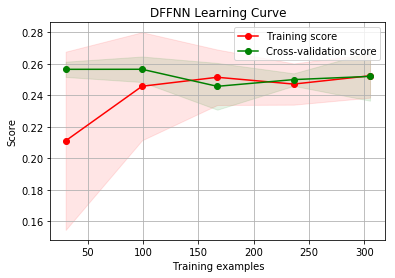

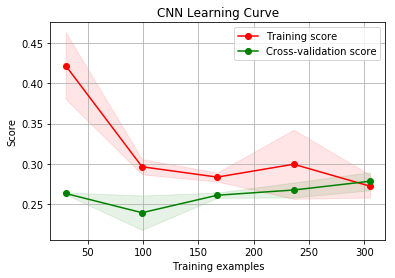

In [24]:
# Print learning curves for each model
steps = 5
for clf in clfs:
    clf_name = str(clf).split()[1]
    params = selected_params[clf_name]
    input_shape = input_shapes[clf_name]
    plot_learning_curve(KerasClassifier(build_fn=clf,**params, verbose=0), 
                        clf_name+' Learning Curve', 
                        X_train.reshape(-1, *input_shape),
                        y_train, 
                        cv=learning_curve_folds,
                        train_sizes=np.linspace(.1,1.0, steps))


# Holdout Experiment

In [25]:
%%time

# Fit best models
fitted_models = {}
for clf in clfs:
    clf_name = str(clf).split()[1]
    all_params = selected_params[clf_name]
    modelling_params = {k:v for k,v in all_params.items() if k in model_params}
    fitting_params = {k:v for k,v in all_params.items() if k in fit_params}
    input_shape = input_shapes[clf_name]
    
    model = clf(**modelling_params)
    history = model.fit(X_train.reshape(-1, *input_shape), 
                        y_train_wide, 
                        **fitting_params,
                        verbose=0)
    
    fitted_models[clf_name] = [model, history]


CPU times: user 35.5 s, sys: 176 ms, total: 35.7 s
Wall time: 27.9 s


****** Test Data ********
SLP
Report:
              precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        23
        1.0       0.21      0.23      0.22        26
        2.0       0.47      0.27      0.34        30
        3.0       0.34      0.65      0.44        37

avg / total       0.28      0.33      0.28       116

Confusion Matrix
 [[ 0  2  2 19]
 [ 0  6  1 19]
 [ 0 13  8  9]
 [ 0  7  6 24]]
Accuracy: 0.327586206897


/home/user1/anaconda3/envs/LunarLander/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


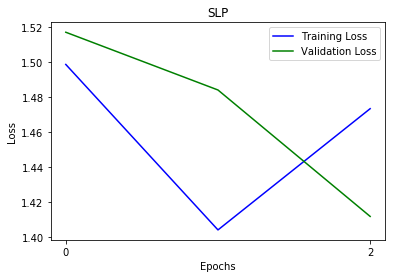

MLP
Report:
              precision    recall  f1-score   support

        0.0       0.15      0.57      0.24        23
        1.0       0.16      0.19      0.17        26
        2.0       0.00      0.00      0.00        30
        3.0       0.00      0.00      0.00        37

avg / total       0.07      0.16      0.09       116

Confusion Matrix
 [[13 10  0  0]
 [21  5  0  0]
 [19 11  0  0]
 [31  6  0  0]]
Accuracy: 0.155172413793


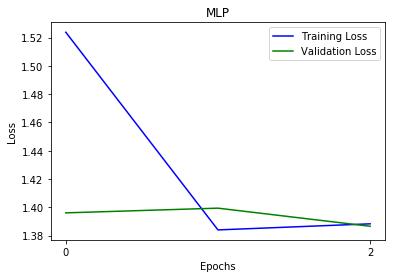

DFFNN
Report:
              precision    recall  f1-score   support

        0.0       0.20      1.00      0.33        23
        1.0       0.00      0.00      0.00        26
        2.0       0.00      0.00      0.00        30
        3.0       0.00      0.00      0.00        37

avg / total       0.04      0.20      0.07       116

Confusion Matrix
 [[23  0  0  0]
 [26  0  0  0]
 [30  0  0  0]
 [37  0  0  0]]
Accuracy: 0.198275862069


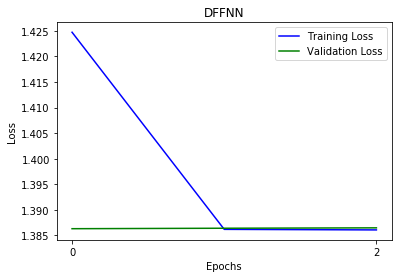

CNN
Report:
              precision    recall  f1-score   support

        0.0       0.19      0.83      0.31        23
        1.0       0.31      0.19      0.24        26
        2.0       0.00      0.00      0.00        30
        3.0       0.00      0.00      0.00        37

avg / total       0.11      0.21      0.11       116

Confusion Matrix
 [[19  4  0  0]
 [21  5  0  0]
 [24  6  0  0]
 [36  1  0  0]]
Accuracy: 0.206896551724


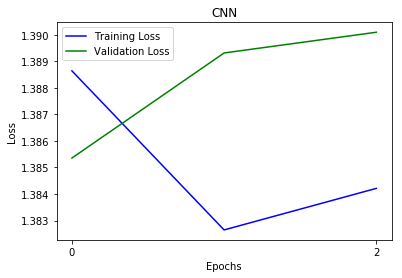

,CNN,DFFNN,MLP,SLP
0,0.207,0.198,0.155,0.328


In [26]:
#Evaluate with Test dataset

print("****** Test Data ********")

holdout_scores ={}
for clf_name, clf_data in fitted_models.items():
    model, history = clf_data
    input_shape = input_shapes[clf_name]
    pred = model.predict(X_test.reshape(-1, *input_shape))
    
    #Decode from 1Hot -> multiclass
    pred = pred.argmax(axis=1)

    #store holdout scores
    holdout_scores[clf_name] = metrics.accuracy_score(y_test, pred)
    
    # Print performance overview
    print(clf_name)
    print('Report:\n',metrics.classification_report(y_test, pred))
    print("Confusion Matrix\n", metrics.confusion_matrix(y_test, pred))

    #Accuracy
    print('Accuracy:',metrics.accuracy_score(y_test, pred))
    print('='*100)

    #plot loss curves
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.title(clf_name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss, 'blue', label='Training Loss')
    plt.plot(val_loss, 'green', label='Validation Loss')
    plt.xticks(range(0,params['epochs'])[0::2])
    plt.legend()
    plt.show()
    
pd.DataFrame(holdout_scores, [0]).round(3)

In [27]:
#Pick best model
the_best = 'CNN'
filepath = "images_player.mod"

#retrieve model and associated data
input_shape = input_shapes[the_best]
model, history = fitted_models[the_best]

#verify its working
model.predict(X_test.reshape(-1, *input_shape))

#save model
model.save(filepath)

#load a model
model = keras.models.load_model("images_player.mod")

#verify its working
model.predict(X_test.reshape(-1, *input_shape))
#Remember Class_label <- np.argmax(predictions)

#summary
model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 8, 64, 64)         80        
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 8, 32, 32)         0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 8, 32, 32)         584       
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 8, 16, 16)         0         
_________________________________________________________________
dropout_91 (Dropout)         (None, 8, 16, 16)         0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_206 (Dense)            (None, 8)                 16392     
__________